[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/annanasnas/semantic_segmentation-25/blob/main/DeepLabV2.ipynb)

In [1]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [5]:
REPO = "https://github.com/annanasnas/semantic_segmentation-25.git"
!git clone $REPO
%cd /content/semantic_segmentation-25
!pip install -q -r requirements.txt pyyaml

Cloning into 'semantic_segmentation-25'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 217 (delta 107), reused 157 (delta 54), pack-reused 0 (from 0)
Receiving objects: 100% (217/217), 3.01 MiB | 16.28 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/semantic_segmentation-25


## Config

In [3]:
import yaml

with open("configs/fda.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

!python scripts/download_data.py

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = cfg["train"]["batch_size"]
epochs = cfg["train"]["epochs"]
learning_rate = cfg["train"]["lr"]

beta = cfg["fda"]["beta"]
charbonnier_eps = cfg["fda"]["charbonnier_eps"]
charbonnier_alpha = cfg["fda"]["charbonnier_alpha"]
lambda_ent = cfg["fda"]["lambda_ent"]

dir_train = cfg["data"]["dir_train"]
dir_val = cfg["data"]["dir_val"]
img_size_train = tuple(cfg["data"]["img_size_train"])
img_size_val = tuple(cfg["data"]["img_size_val"])

name = cfg["model"]["name"]

## DataLoaders

In [4]:
from datasets.cityscapes import CityScapes
from datasets.gta5 import GTA5Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2


imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# augmenations
image_aug_transforms = A.Compose([
    A.RandomScale(scale_limit=(0.0, 0.5), p=0.5),
    A.PadIfNeeded(min_height=720, min_width=1280,
                  border_mode=cv2.BORDER_CONSTANT,
                  value=0,
                  mask_value=255),
    A.RandomCrop(height=720, width=1280, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(5, 5), p=0.5),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])



/tmp/ipython-input-4-1882021751.py:21: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=720, min_width=1280,


In [5]:
train_dataset = GTA5Dataset(
    root_dir=dir_train,
    image_transform=image_aug_transforms,
    image_size=img_size_train,
    FDA=True,
    beta=beta
)

val_dataset = CityScapes(
    root_dir=dir_val,
    split="val",
    image_transform=image_transforms,
    image_size=img_size_val
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## FDA visualization

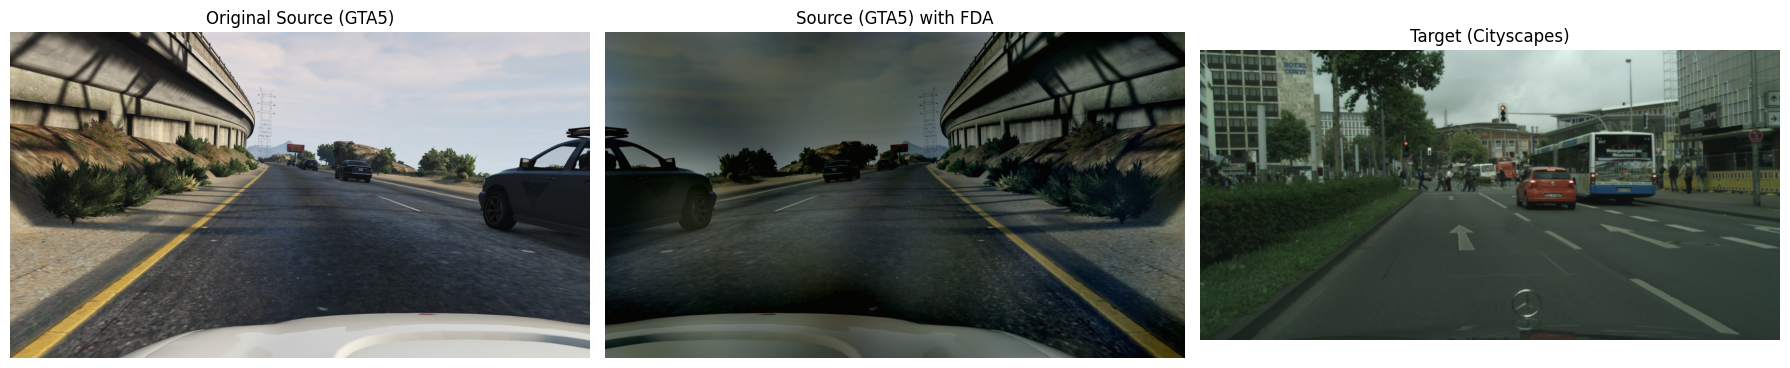

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torchvision.transforms import ToTensor
from scripts.utils import denormalize
from PIL import Image


idx_src = random.randint(0, len(train_dataset) - 1)
idx_trg = random.randint(0, len(val_dataset) - 1)

src_path = train_dataset.image_paths[idx_src]
original_src_img = Image.open(src_path).convert("RGB").resize((1280, 720))
original_src_np = np.array(original_src_img)

src_img, _, _ = train_dataset[idx_src]
src_img_np = denormalize(src_img.clone()).permute(1, 2, 0).numpy()
src_img_np = np.clip(src_img_np * 255, 0, 255).astype(np.uint8)

trg_img, _ = val_dataset[idx_trg]
trg_img_np = denormalize(trg_img.clone()).permute(1, 2, 0).numpy()
trg_img_np = np.clip(trg_img_np * 255, 0, 255).astype(np.uint8)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_src_np)
plt.title("Original Source (GTA5)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(src_img_np)
plt.title("Source (GTA5) with FDA")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(trg_img_np)
plt.title("Target (Cityscapes)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Training

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
import torch.optim as optim
import torch.nn as nn
from models.bisenet.build_bisenet import BiSeNet
from scripts.train import train_bisenet_FDA
from torch.amp import autocast, GradScaler
from scripts.checkpoint import Checkpoint
from pathlib import Path
import pandas as pd


model = BiSeNet(num_classes=19, context_path='resnet18')
optimizer = optim.SGD(model.optim_parameters(lr=learning_rate), momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
scaler = GradScaler()

model.to(device)

ckpt_dir = Path("/content/drive/MyDrive/semantic segmentation/checkpoints") / name
log_csv  = ckpt_dir / "log.csv"
ckpt_mgr = Checkpoint(ckpt_dir)
ckpt = Checkpoint(ckpt_dir)

best_path = ckpt_dir / "best.pth"
if best_path.exists():
    ckpt = torch.load(best_path, map_location="cpu", weights_only=False)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    scaler.load_state_dict(ckpt["scaler"])
    start_epoch = ckpt["epoch"]
    iteration = ckpt["iteration"]
    best_miou   = ckpt["best_miou"]
    df_prev = pd.read_csv(log_csv)
    metrics = df_prev.to_dict("list")
else:
    start_epoch = 0
    best_miou   = 0
    iteration = 0
    metrics = {"epoch": [], "train_loss": [], "val_loss": [], "val_miou": []}

max_iter = len(train_dataloader) * epochs
train_bisenet_FDA(model, train_dataloader, val_dataloader,
                  device, epochs, autocast, scaler,
                  optimizer, criterion, learning_rate,
                  iteration, max_iter,
                  ckpt_mgr, start_epoch, best_miou,
                  log_csv, metrics,
                  charbonnier_eps, charbonnier_alpha, lambda_ent)


# Results

In [15]:
from scripts.utils import evaluate_miou

CITYSCAPES_CLASSES = [
    'Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 'Pole', 'Traffic light',
    'Traffic sign', 'Vegetation', 'Terrain', 'Sky', 'Person', 'Rider', 'Car',
    'Truck', 'Bus', 'Train', 'Motorcycle', 'Bicycle'
]

model = BiSeNet(num_classes=19, context_path='resnet18')
model.to(device)
best_model = torch.load(best_path, map_location=device, weights_only=False)
model.load_state_dict(best_model["model_state_dict"]) #model
ious = evaluate_miou(model, val_dataloader, device) * 100

print("Per-class IoU")
for idx, (cls_name, iou) in enumerate(zip(CITYSCAPES_CLASSES, ious)):
    print(f"{cls_name:16s}: {iou:.4f}")
print(f"Mean IoU: {np.nanmean(ious):.4f}")

Per-class IoU
Road            : 86.4313
Sidewalk        : 31.2409
Building        : 80.6778
Wall            : 25.0864
Fence           : 20.2249
Pole            : 25.6280
Traffic light   : 21.5404
Traffic sign    : 11.0981
Vegetation      : 78.2781
Terrain         : 20.1486
Sky             : 78.7141
Person          : 48.2738
Rider           : 10.6597
Car             : 69.6148
Truck           : 20.9050
Bus             : 27.6227
Train           : 0.8169
Motorcycle      : 7.5762
Bicycle         : 0.0000
Mean IoU: 34.9757
